In [135]:
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from itertools import permutations, accumulate
import torch.nn.functional as F
import time
import operator
import math

%matplotlib inline

# https://medium.com/deep-learning-hk/compute-document-similarity-using-autoencoder-with-triplet-loss-eb7eb132eb38
# https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
# FaceNet: https://arxiv.org/pdf/1503.03832.pdf

In [230]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [3]:
def dfCheck(df):
    
    # Any column is > 20% null values
    if any(cnt / len(df) > 0.2 for cnt in df.isna().sum()):
        return False
    
    return True

In [4]:
tables = defaultdict(list)
path = "../Data/tables_025.csv"
maxRowLen = 0
maxRowLenR = ""
maxRowLenT = ""
allRows = []

with open(path, "r") as f:
    tableCount = 0
    for line in f:
        if line.startswith("List of"):
            tableCount += 1
            
tableFrac = 0.25
tablesLim = int(tableCount * tableFrac)
tablesRead = 0

print("Reading " + str(tablesLim) + " tables")

with open(path, "r") as f:
    reader = csv.reader(f)
    tableTitle = ""
    table = []
    
    for row in reader:
        if len(row) == 1 and row[0].startswith("List of"):
            if tableTitle: # Ignore first table, doesn't exist yet
                if dfCheck(pd.DataFrame(table)):
                    joinedRows = ['|||'.join(row) for row in table]
                    tables[tableTitle].append(joinedRows)
                    allRows.extend(joinedRows)
                table = []
            tableTitle = row[0]
            
            tablesRead += 1
            if tablesRead > tablesLim:
                break
            
        elif len(row) != 0:
            table.append(row)
            
            
print("Total tables analyzed: " + str(sum(len(val) for val in tables.values())))
maxRowLen = max(len(row) for row in allRows)
print("Maximum row length: " + str(maxRowLen))

Reading 41575 tables
Total tables analyzed: 39393
Maximum row length: 1017


In [5]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(allRows)
id_count = len(tokenizer.word_index)

In [6]:
"""
Convert each string into a list of its characters, converted to ints
Filter out rows which are too long (i.e. not many other rows at that length)
"""
import json

table_chars = []
sizes = [len(seq) for seq in allRows]
mu, sigma = np.mean(sizes), np.std(sizes)
maxRowLen = int(mu)

for i, category in enumerate(tables):
    for i, table in enumerate(tables[category]):
        tokens = tokenizer.texts_to_sequences(table)
        char_table = np.array([np.pad(seq, (0, maxRowLen - len(seq))) for seq in tokens if len(seq) <= maxRowLen])

        if len(char_table) >= 10:  # Remove tables that no longer have sufficient rows. We use 10 to allow for training & testing purposes   
            table_chars.append(char_table)

table_tensors = [torch.tensor(table) for table in table_chars]
print("Total # of tables in dataset: " + str(len(table_tensors)))

Total # of tables in dataset: 15762


In [7]:
# with open("../Data/tables.json", "w") as f:
#     f.write(json.dumps([l.tolist() for l in table_chars]))

In [251]:
from sklearn.metrics import average_precision_score

class TableDataset(torch.utils.data.Dataset):
    def __init__(self, tables):
        self.sizes = torch.tensor([table.shape[0] for table in tables])
        self.table_positions = self.get_table_positions()
        self.rows = torch.cat(tables, 0).float()
        self.max = torch.max(self.rows)
        self.rows = self.rows / self.max  # Normalization

    def __len__(self):
        return len(self.sizes)

    def __getitem__(self, idx):
        if idx == 0:
            return self.rows[:self.sizes[0]]
            
        return self.rows[self.sizes[idx-1]:self.sizes[idx]]

    def get_table_positions(self):
        return np.array([0] + list(accumulate(self.sizes, operator.add)), dtype=np.int32)

    def shuffle(self):
        idxs = np.random.permutation(len(self.sizes))
        tables = torch.split(self.rows, list(self.sizes))  # split_size_or_sections needs a list for some reason
        tables = [tables[idx] for idx in idxs]
        self.rows = torch.cat(tables, 0)
        self.sizes = self.sizes[idxs]
        self.table_positions = self.get_table_positions()
        return

    def get_batch(self, model, start_idx, batch_size):
        """
        Using an online novel triplet mining strategy described in https://arxiv.org/pdf/1503.03832.pdf
        
        We perform all computations in numpy since it is much faster than with pytorch
        """
        # t = time.time()
        table_positions = self.table_positions[start_idx: start_idx+batch_size+1]

        # Get 5 rows per table for a subset of the tables
        chosen_row_idxs = np.arange(table_positions[0], table_positions[-1])
        chosen_rows = self.rows[table_positions[0]:table_positions[-1],:].float().to(device)

        # turn off autograd to speed up computation
        with torch.no_grad():
            embeddings = np.array(model(chosen_rows).cpu())
    
        dists = np.matmul(embeddings, embeddings.T)

        pos_mask = np.zeros(dists.shape)
        for start, end in zip(table_positions, table_positions[1:]):
            pos_mask[start:end,start:end] = 1
        
        # print("Elapsed: " + str(time.time() - t), len(chosen_rows), len(anchor_idxs))
        return (
            chosen_rows.to(device), 
            torch.tensor(pos_mask).float().to(device)
        )

    def get_average_precision(self, model, first_tables=20):
        with torch.no_grad():
            embs = np.array(model(self.rows.long().to(device)).cpu())  # Our model uses small => better, avg_precision uses opposite
        precs = []

        dists = np.matmul(embs, embs.T)
        pos_mask = np.zeros(dists.shape, dtype=bool)
        
        for table_start, table_end in zip(self.table_positions[:first_tables], self.table_positions[1:first_tables]):
            pos_mask[table_start:table_end,table_start:table_end] = 1

        for mask, scores in zip(pos_mask, dists):
            # print(mask, scores)
            avg_prec_score = average_precision_score(mask, scores)
            precs.append(avg_prec_score)

        return precs

table_tensors_train = []
table_tensors_val = []
table_tensors_test = []
take_tables = 100
torch.manual_seed(42)

# Generate training, validation, and testing datasets
for table in table_tensors[:take_tables]:
    # Select 5 random rows to be validation / test rows
    non_train_idxs = torch.randint(0, table.shape[0], size=(1, 5)).flatten()
    val_idxs, test_idxs = non_train_idxs[:3], non_train_idxs[3:]

    # All other rows are training rows
    train_idxs = torch.ones(table.shape[0], dtype=bool)
    train_idxs[non_train_idxs] = False

    # append the data to appropriate list
    table_tensors_train.append(table[train_idxs])
    table_tensors_val.append(table[val_idxs])
    table_tensors_test.append(table[test_idxs])

dataset_train = TableDataset(table_tensors_train)
dataset_val = TableDataset(table_tensors_val)
dataset_test = TableDataset(table_tensors_test)

In [252]:
"""
Model based on https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
"""

class LinearModel(nn.Module):
    def __init__(self, emb_dim, h_activ=nn.ReLU()):
        super().__init__()
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(maxRowLen, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, emb_dim)
          )

    def forward(self, x):
        out = self.fc1(x)
        return F.normalize(out, p=2, dim=-1)

# class APLoss(nn.Module):
#     """
#     https://openaccess.thecvf.com/content_ICCV_2019/papers/Revaud_Learning_With_Average_Precision_Training_Image_Retrieval_With_a_Listwise_ICCV_2019_paper.pdf
#     """
#     def __init__(self, M):
#         super(APLoss,self).__init__()
#         self.M = torch.tensor(M)
#         self.delta = torch.tensor(2 / (M - 1))
#         self.bin_centers = torch.tensor([1 - (m - 1)*self.delta for m in range(1, M+1)])

#     def forward(self, s, y):

#         sims = torch.matmul(s, s.T)
#         APs = torch.tensor([self.AP(sim.T, truth) for sim, truth in zip(sims, y)])
#         mAP = torch.sum(APs)

#         return 1 - mAP / s.shape[0]

#     def AP(self, sims, truth):
#         precisions = torch.tensor([self.quantized_precision(sims, truth, m_prime) for m_prime in range(1, self.M+1)])
#         recalls = torch.tensor([self.incremental_recall(sims, truth, m_prime) for m_prime in range(1, self.M+1)])
#         return torch.sum(precisions * recalls)

#     def quantized_precision(self, S_q, Y_q, m):
#         numerator = 0
#         denominator = 0
#         for m_prime in range(1, m+1):
#             sigma_res = self.sigma(S_q, m_prime)
#             numerator += torch.matmul(sigma_res.T, Y_q)
#             denominator += torch.sum(sigma_res)
        
#         return numerator / denominator

#     def incremental_recall(self, S_q, Y_q, m):
#         N_q = torch.count_nonzero(Y_q)  # Not sure this is correct
#         return torch.matmul(self.sigma(S_q, m).T, Y_q) / N_q

#     def sigma(self, x, m):
#         return torch.relu(1 - torch.abs((x - self.bin_centers[m-1]) / self.delta))


class APLoss (nn.Module):
    """ Differentiable AP loss, through quantization. From the paper:
        Learning with Average Precision: Training Image Retrieval with a Listwise Loss
        Jerome Revaud, Jon Almazan, Rafael Sampaio de Rezende, Cesar de Souza
        https://arxiv.org/abs/1906.07589
        Input: (N, M)   values in [min, max]
        label: (N, M)   values in {0, 1}
        Returns: 1 - mAP (mean AP for each n in {1..N})
                 Note: typically, this is what you wanna minimize
    """
    def __init__(self, nq=5, min=0, max=1):
        nn.Module.__init__(self)
        assert isinstance(nq, int) and 2 <= nq <= 100
        self.nq = nq
        self.min = min
        self.max = max
        gap = max - min
        assert gap > 0
        # Initialize quantizer as non-trainable convolution
        self.quantizer = q = nn.Conv1d(1, 2*nq, kernel_size=1, bias=True)
        q.weight = nn.Parameter(q.weight.detach(), requires_grad=False)
        q.bias = nn.Parameter(q.bias.detach(), requires_grad=False)
        a = (nq-1) / gap
        # First half equal to lines passing to (min+x,1) and (min+x+1/a,0) with x = {nq-1..0}*gap/(nq-1)
        q.weight[:nq] = -a
        q.bias[:nq] = torch.from_numpy(a*min + np.arange(nq, 0, -1))  # b = 1 + a*(min+x)
        # First half equal to lines passing to (min+x,1) and (min+x-1/a,0) with x = {nq-1..0}*gap/(nq-1)
        q.weight[nq:] = a
        q.bias[nq:] = torch.from_numpy(np.arange(2-nq, 2, 1) - a*min)  # b = 1 - a*(min+x)
        # First and last one as a horizontal straight line
        q.weight[0] = q.weight[-1] = 0
        q.bias[0] = q.bias[-1] = 1

    def forward(self, sims, label, qw=None, ret='1-mAP'):
        x = torch.matmul(sims, sims.T).T
        assert x.shape == label.shape  # N x M
        N, M = x.shape
        # Quantize all predictions
        q = self.quantizer(x.unsqueeze(1))
        q = torch.min(q[:, :self.nq], q[:, self.nq:]).clamp(min=0)  # N x Q x M

        nbs = q.sum(dim=-1)  # number of samples  N x Q = c
        rec = (q * label.view(N, 1, M).float()).sum(dim=-1)  # number of correct samples = c+ N x Q
        prec = rec.cumsum(dim=-1) / (1e-16 + nbs.cumsum(dim=-1))  # precision
        rec /= rec.sum(dim=-1).unsqueeze(1)  # norm in [0,1]

        ap = (prec * rec).sum(dim=-1)  # per-image AP

        if ret == '1-mAP':
            if qw is not None:
                ap *= qw  # query weights
            return 1 - ap.mean()
        elif ret == 'AP':
            assert qw is None
            return ap
        else:
            raise ValueError("Bad return type for APLoss(): %s" % str(ret))

    def measures(self, x, gt, loss=None):
        if loss is None:
            loss = self.forward(x, gt)
        return {'loss_ap': float(loss)}

In [253]:
def train(model, optimizer, loss_fn, data, BATCH_SIZE=100):
    model.train()
    losses = []

    for i in range(0, len(data), BATCH_SIZE):
        batch, mask = data.get_batch(model, i, BATCH_SIZE)

        model.zero_grad()
        optimizer.zero_grad()
        batch_embs = model(batch)    
        loss = loss_fn(batch_embs, mask)
        loss.backward() # back-propagation, could do manually
        optimizer.step() # Adjusts the weights for us
        losses.append(loss.item())

    return losses

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        precision_scores = data.get_average_precision(model)

    return precision_scores

EPOCHS = 1000
model = LinearModel(256).to(device)
loss_fn = APLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr = 1e-1, weight_decay=0.0005)
train_losses = []
precision_scores = []

for epoch in range(EPOCHS):
    print("EPOCH: " + str(epoch))

    dataset_train.shuffle()
    train_losses += train(model, optimizer, loss_fn, dataset_train)

    # if epoch % 100 == 0:
        # dataset_val.shuffle()
        # prec = evaluate(model, dataset_val)
        # precision_scores.extend(prec)
        # print("Average Precision at epoch %s: %s" % (epoch, np.mean(prec)))

EPOCH: 0


KeyboardInterrupt: 

In [247]:
"""
Test to make sure that a single pass over 'get_triplets' works as intended
"""
batch, mask = dataset_val.get_batch(model, 0, 2)

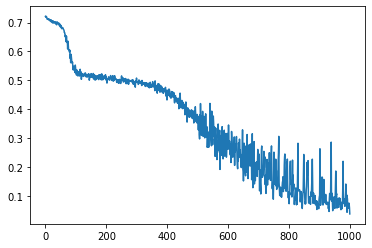

In [250]:
plt.plot(train_losses)

In [242]:
batch, mask = dataset_train.get_batch(model, 0, 25)
embs = model(batch) 
l = loss_fn(embs, mask)

[('fc1.0.weight', Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True)), ('fc1.0.bias', Parameter containing:
tensor([    nan,     nan,     nan,     nan,     nan, -0.0951,     nan, -0.1124,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan, -0.0728,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,  0.0093,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan

In [124]:
for x, y in model.named_parameters():
    print(x, y)

fc1.0.weight Parameter containing:
tensor([[-0.0449,  0.0578,  0.0582,  ...,  0.0014,  0.0099, -0.0116],
        [ 0.1102,  0.1143,  0.0734,  ..., -0.0984, -0.0091, -0.0624],
        [-0.0865,  0.0092, -0.1081,  ..., -0.0036, -0.0727,  0.0977],
        ...,
        [ 0.0140, -0.0578,  0.1152,  ..., -0.0385, -0.1113, -0.0516],
        [ 0.0740, -0.1186, -0.0937,  ...,  0.0045, -0.0644,  0.0297],
        [-0.0309, -0.0109, -0.0004,  ..., -0.0372, -0.1175,  0.0393]],
       device='cuda:0', requires_grad=True)
fc1.0.bias Parameter containing:
tensor([-3.9403e-02,  8.3817e-02, -5.3455e-02,  6.8932e-02,  4.5411e-02,
         6.7924e-03,  2.6026e-02,  4.2263e-02, -8.7272e-05, -1.0197e-01,
        -2.3098e-02, -5.0014e-03,  1.0178e-01,  3.7622e-02, -9.9214e-02,
        -1.0024e-01,  1.8203e-02,  1.0494e-01,  4.0220e-02,  7.0058e-02,
        -7.5623e-02, -1.1379e-01,  1.1467e-01, -7.9106e-02, -8.6283e-02,
         6.2961e-02, -6.5376e-02,  4.4567e-02,  7.6907e-02,  4.2444e-02,
         4.4839e

tensor(5)